---
title: A Short Introduction to Bayesian Inference
authors:
  - name: David Wright
    id: dw
    orcid: 0000-0003-1562-4679
    email: david.wright@nanograv.org
    affiliation:
      - name: Oregon State University
        city: Corvallis
        state: OR
        url: https://www.oregonstate.edu
bibliography:
  - local-bib.bib
date: 2025-06-16
---

# Bayesian Statistics

The process of Bayesian data analysis can be idealized by dividing it into the following three steps (from @gelmanBayesianDataAnalysis) :

1. **Setting up a full probability model**---a joint probability distribution for all observable and unobservable quantities in a problem. The model should be consistent with knowledge about the underlying scientific problem and the data collection process.

2. **Conditioning on observed data**: calculating and interpreting the appropriate posterior distribution—the conditional probability distribution of the unobserved quantities of ultimate interest, given the observed data.

3. **Evaluating the fit of the model and the implications of the resulting posterior distribution**:
how well does the model fit the data, are the substantive conclusions reasonable, and how sensitive are the results to the modeling assumptions in step 1? In response, one can alter or expand the model and repeat the three steps.

## Notation
- $\theta$ : unobservable parameters that we want to *infer*
- $y$ : observed data
- $\tilde{y}$ : unobserved but potentially observable quantity
- $\mathbf{x}$ : vector quantity always assumed to be a **column** vector
- $p ( \cdot )$ : probability density function or discrete probability (from context)
- $p ( \cdot \mid \cdot )$ : conditional probability 

## Bayes' Theorem
In order to make probability statements about $\theta$ given $y$, we must build a model that provides a joint probability distribution for $\theta$ and $y$.
We can write the joint distribution as a product of two distributions: 
- the *prior* $p(\theta)$ and
- the *sampling distribution* $p(y \mid \theta)$. For fixed $y$ we call this the *likelihood*

```{math}
p(\theta, y) = p(y \mid \theta) p(\theta).
```

Assuming we are given $p(y)$ instead, we could write
```{math}
p(\theta, y) = p(\theta \mid y) p(y).
```

Putting these together, we arrive at [Bayes' Theorem](wiki:Bayes'_theorem):

```{math}
:label: bayes-thm-full
p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{p(y)}.
```

Typically, computing $p(y) = \int d\theta\, p(\theta)(y \mid \theta)$ in {eq}`bayes-thm-full`, called the *evidence*, is intractable. However, it is a constant. Consequently, we often write Bayes' Theorem as a proportional relation:
```{math}
:label: bayes-thm
p(\theta \mid y) \propto p(y \mid \theta) p(\theta).
```


## Example from Genetics
This example is also from @gelmanBayesianDataAnalysis.

Biological human males have one X-chromosome and one Y-chromosome, whereas females have two X-chromosomes, each chromosome being inherited from one parent.
Hemophilia is a disease that exhibits X-chromosome-linked recessive inheritance, meaning that a male who inherits the gene that causes the disease on the X-chromosome is affected, whereas a female carrying the gene on only one of her two X-chromosomes is not affected.
The disease is generally fatal for women who inherit two such genes, and this is rare, since the frequency of occurrence of the gene is low in human populations.

**Prior distribution**: Consider a woman who has an affected brother, which implies that her mother must be a carrier of the hemophilia gene with one "good" and one "bad" hemophilia gene.
Her father is not affected; thus the woman herself has a fifty-fifty chance of having the gene.
Therefore, the woman is either a carrier of the gene $(\theta = 1)$ or not $(\theta = 0)$.
The prior distribution for the unknown $\theta$ is then 
```{math}
:label: prior-gen
p(\theta = 1) = p(\theta = 0) = 0.5 .
```

**Data model and likelihood**: The data will be the the status of the woman's sons.
Let $y_i = 1$ or 0 denote an affected or unaffected son, respectively.
Suppose she has two sons, neither of whom is affected. Assume that there is no covariance between the sons' conditions. The likelihood is then
```{math}
:label: likelihood-gen-1
p(y_1 =0, y_2 = 0 \mid \theta = 1) = 0.5 \cdot 0.5 = 0.25
```
```{math}
:label: likelihood-gen-2
p(y_1 =0, y_2 = 0 \mid \theta = 0) = 1 \cdot 1 = 1
```

**Posterior distribution**: We can now use Bayes' Theorem in the form {eq}`bayes-thm-full` to find the posterior probability that the woman has the gene. Let $y = (y_1, y_2)$.

```{exercise} 
:label: exercise-gen-post
Find $p(\theta = 1 \mid y)$
```

````{solution} exercise-gen-post
:class: dropdown
:label: exercise-gen-post-sol
```{math}
:label: posterior-gen
\begin{align}
p(\theta = 1 \mid y) &= \frac{p ( y \mid \theta = 1) p(\theta = 1)}{p(y \mid \theta = 1)p(\theta=1) + p (y \mid\theta =0) p(\theta=0)} \\
&= \frac{0.25 \cdot 0.5}{0.25 \cdot 0.5 + 1 \cdot 0.5} \\
&= 0.20.
\end{align}
```
````

**Updating Our Knowledge**: Assume we find a long-lost third son that also does not carry the gene. We can use the the *posterior* from the previous analysis as the *prior* for our new analysis with the third son included.

```{exercise}
:label: exercise-gen
Update posterior probability of the woman's carrier status $(\theta =0,1)$ with the third son's condition.
```

````{solution} exercise-gen
:class: dropdown
:label: exercise-gen-sol
Using the formula from {eq}`posterior-gen`

```{math}
\begin{align}
p(\theta = 1 \mid y) &= \frac{0.5 \cdot 0.20}{0.5 \cdot 0.20 + 1 \cdot 0.8 }\\
&= 0.111.
\end{align}
```
````

# Building Bayesian Models with Probabilistic Programming Languages
Let's switch over from genetics to astronomy and learn how to infer the value of the Hubble constant.
I've prepared some data at `h_z_measurements.feather`.

First, lets import the packages we'll need for this section.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import arviz as az
import numpyro
import pandas as pd
from numpyro import distributions as dist
from numpyro import infer

In [2]:
df = pd.read_feather("h_z_measurements.feather")
df

,H_z,z,H_z_err
0,72.411583,0.000000,5.409743
1,79.922890,0.040404,9.752816
2,71.289124,0.080808,1.973352
3,82.794106,0.121212,6.509028
4,78.363434,0.161616,0.880721
...,...,...,...
95,402.359650,3.838384,1.253220
96,408.457550,3.878788,2.594271
97,409.819092,3.919192,0.824300
98,411.225433,3.959596,4.221091


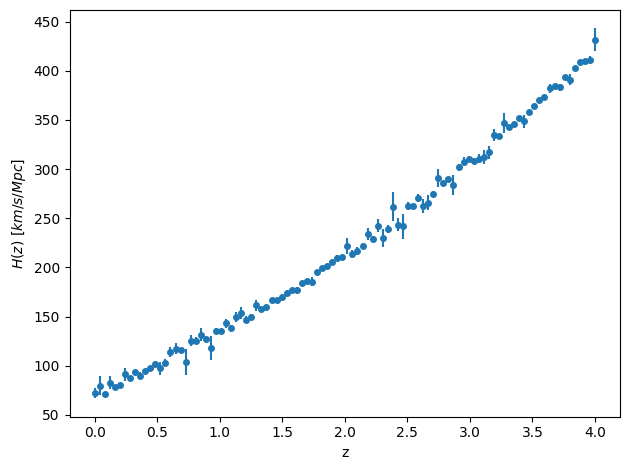

In [3]:
_ = plt.errorbar(
    df["z"], df["H_z"], yerr=df["H_z_err"], fmt="o", markersize=4
)
plt.xlabel("z")
plt.ylabel(r"$H(z)\ \left[km / s/Mpc\right]$")
plt.tight_layout()

This is inspired by the recent DESI release. We could of course just look at $z=0$, so this data is overkill. We will expand on this model later to infer other parameters.

To build our model, we need to gather all the information we have about the Hubble parameter as a function of redshift. The Friedmann equations (with some extra terms we'll talk about later) lead to 
```{math}
:label: h-of-z
H(z) = H_0 \left(\Omega_m (1+z)^3 + \Omega_r (1+z)^4 + \Omega_{\Lambda} (1+z)^{3 (1+ w_0 +w_a)} e^{-3 w_a \left(\frac{z}{1+z}\right)}\right)^{1/2}.
```

- To start with, we'll assume all parameters take their $\Lambda CDM$ values and infer *just* on $H_0$. 

- Our data are the $H(z)$ values observed at the corresponding redshifts. Call them $H_{obs}$

- The data looks to have some random noise scattered around a trend. We'll choose a Gaussian likelihood to account for this.
  - We need a forward model for our expected $H(z)$ value that is a function of redshift and $H_0$. Let's create that.
 

In [4]:
def hz_forward(z, h0=67.0, omega_matter=0.3, omega_de=0.7, omega_rad=5.5e-5, w0=-1.0, wa=0.0):
    """Hubble parameter as function of redshift. Default parameters are LCDM."""
    a_inv = 1+z
    return h0 * jnp.sqrt(
        omega_matter * (a_inv) ** 3
        + omega_rad * (a_inv) ** 4
        + omega_de * (a_inv) ** (3 * (1 + w0 + wa)) * jnp.exp(-3 * wa * (z / (a_inv)))
    )

- We also need to quantify our prior beliefs about $H_0$. Let's assume very wide priors and say that we believe with equal probability that $H_0$ can be anywhere from 50 to 100.

- Putting everything together in our notation from earlier,
```{math}
\begin{align}
\theta & = H_0 \\
y_i &= H_{obs,\, i} \\
y_{err,\, i} &= H_{obs,\, i} \textrm{ uncertainty} \\
y_{pred,\, i} &= H_{model}(\theta, z_i) \\
p(\theta) & = U(50, 100) \\
p(y_i \mid \theta) &= \mathcal{N}(y_i \mid y_{pred,\, i},y_{err,\, i})
\end{align}
```

And finally,
```{math}
:label: basic-hz-posterior
p(\theta \mid y) \propto \prod_i \mathcal{N}(y_i \mid y_{pred,\,i },\,y_{err,\,i})\cdot U(50, 100).
```

Note that the product comes about because each data point is independent.

## How would we implement this in code?
This is where a probabilistic (PPL) comes in. A PPL usually has the following capabilities:

- Stochastic primitives and distributions as first-class citizens
- Model building frameworks
- Inference routines that can consume the models and automatically adjust/tune themselves

## What PPLs are out there?
There are many! The ones that are most popular in the Python ecosystem are
- [PyStan](https://pystan.readthedocs.io/en/latest/)
- [PyMC](https://www.pymc.io/projects/docs/en/stable/learn.html)
- [Pyro](https://pyro.ai/)
- [NumPyro](https://num.pyro.ai/en/latest/index.html#)

Each has their own benefits and drawbacks. Today, we'll focus on NumPyro. Let's see how to implement our Hubble parameter model in NumPyro.

## NumPyro Basics
`NumPyro` is a PPL built on `JAX`. It comes with a large selection of distributions, inference routines, and model building tools.

- `NumPyro` models are simple Python functions.
- Within the function, we can call `numpyro.distributions.<some-distribution>` for each parameter we need to sample.
- For our likelihood, we can also use a built-in distribution. If we tell `NumPyro` we have observed data, it will automatically calculate the probability for that data given the likelihood.

The easiest way to see this is with an example. Lets fit a simple Gaussian.

Start by creating some data.

In [5]:
key = jax.random.key(117)
data = jax.random.multivariate_normal(
    key, jnp.array([2, 3]), cov=jnp.array([[1, 0], [0, 1]]), shape=(500,)
)

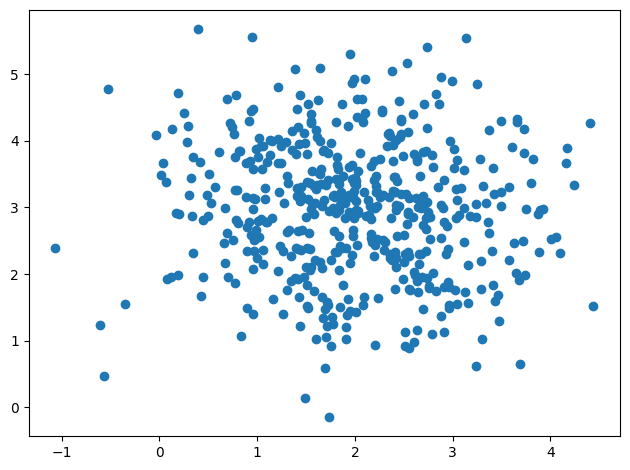

In [6]:
_ = plt.scatter(*data.T)
plt.tight_layout()

Now, we'll build the `NumPyro` model. As arguments, it needs to take the input data.

In [7]:
def simple_2d_gaussian(data=None):
    # Get the mean vector
    mu = numpyro.sample("mu", dist.Uniform(-5, 5), sample_shape=(2,))

    # We'll assume a diagonal covariance
    cov_diag = numpyro.sample("cov_diag", dist.Uniform(-10, 10), sample_shape=(2,))

    # Arbitrary transformations are fine!
    # "Deterministic" stores them in the trace
    cov = numpyro.deterministic("cov_mat", jnp.diag(cov_diag))

    # The data are independent
    with numpyro.plate("data", data.shape[0]):
        # Get the likelihood
        numpyro.sample(
            "loglike", dist.MultivariateNormal(loc=mu, covariance_matrix=cov), obs=data
        )

This creates a model that we can visualize as a [probabilistic graphical model](wiki:Graphical_model) or more specifically a [Bayesian network](wiki:Bayesian_network).

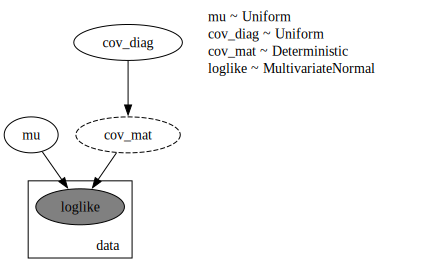

In [8]:
numpyro.render_model(simple_2d_gaussian, model_args=(data,), render_distributions=True)

Now, we can pass off our model to a routine that will approximate the posterior. Let's first, however, take a detour and let you build your own `NumPyro` model.

```{exercise}
:label: exercise-ppl
Using `NumPyro`, build the model we defined in {eq}`basic-hz-posterior`.
Also render a Bayesian network representing your model. Does is look how you expect?
```

```{solution} exercise-ppl
:class: dropdown
:label: exercise-ppl-sol

```{code} python
def hz_model(z, hz, hz_err):
    h0 = numpyro.sample("h0", dist.Uniform(50,100))
    with numpyro.plate("data", hz.shape[0]):
        numpyro.sample("loglike", dist.Normal(hz_forward(z, h0=h0), hz_err), obs=hz)

numpyro.render_model(hz_model, model_args=(df['z'].to_numpy(), df['H_z'].to_numpy(), df['H_z_err'].to_numpy()), render_distributions=True)
```

# Approximating Posterior Distributions
Now that we have our model built, we need a way to find the posterior distribution of the parameters of interest.
In very rare circumstances, our posterior has a closed form expression (see [conjugate priors](wiki:Conjugate_prior)).
Most of the time, we need numerical approximations to learn about the posterior.

One of, if not the most, ubiquitous algorithms for this purpose is Markov Chain Monte Carlo

## Markov Chain Monte Carlo (MCMC)
This algorithm allows us to draw *samples* from a posterior when we do not know or cannot calculate the posterior distribution from first principles.
The name comes from the merging of two statistical ideas: Markov Chains and Monte Carlo processes.

- [Markov Chains](wiki:Markov_chain): a stochastic process describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event.
- [Monte Carlo methods](wiki:Monte_Carlo_method): computational algorithms that rely on repeated random sampling to obtain numerical results
  
MCMC works in the following way:

1. The chain of posterior samples is at $x$
2. A new location $x'$ is drawn from a proposal distribution $q(x)$, which we'll use $q(x) \sim \mathcal{N}(x,\sigma))$.
3. The ratio of the target probability density at the proposed location to the current location is calculated, $\alpha = \frac{p(x')}{p(x)}$ .
4. If $\alpha \gt 0$ the jump is accepted, if $\alpha < 1$ it's accepted with a probability of $\alpha$. If a jump is rejected the current sample is repeated in the chain.

See https://chi-feng.github.io/mcmc-demo/

We'll create a simple distribution by hand and then draw samples from it.

In [9]:
def pdf(x, mu=10, sigma=2.0):
    "Gaussian PDF"
    return (
        1 / jnp.sqrt(2 * jnp.pi * sigma**2) * jnp.exp(-((x - mu) ** 2) / (2 * sigma**2))
    )


def p(x):
    return 0.5 * (pdf(x, mu=10, sigma=2.0) + pdf(x, mu=15, sigma=1))

In [10]:
from scipy.stats import norm
from tqdm import tqdm
key , _= jax.random.split(key)
x0 = -7.0
x = x0
p_current = p(x0)
chain = [x]
probs = [p_current]

niter = 10000
sigma_jump = 5.

for i in tqdm(range(niter)):
    xp = norm.rvs(loc=x, scale=sigma_jump)
    p_p = p(xp)
    
    α = p_p/p_current
    u = jax.random.uniform(key)
    key, _ = jax.random.split(key)
    accepted = u < α
    
    if accepted:
        x = xp
        p_current = p_p
    chain.append(x)
    probs.append(p_current)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3191.26it/s]


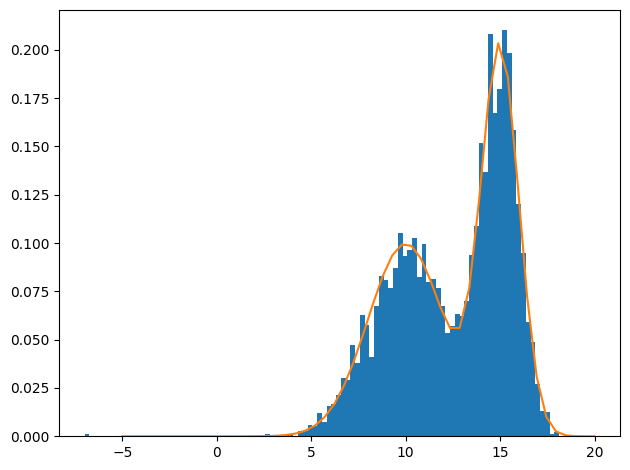

In [11]:
plt.hist(chain, bins=100, density=True)
_ = plt.plot(jnp.linspace(-5,20), p(jnp.linspace(-5,20)))
plt.tight_layout()

We can use `ArviZ` to explore our posterior more. Here's an example.

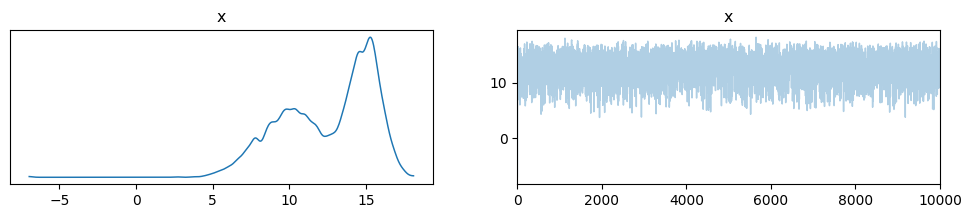

In [12]:
simple_inf_data = az.from_dict({"x":chain})
_ = az.plot_trace(simple_inf_data)

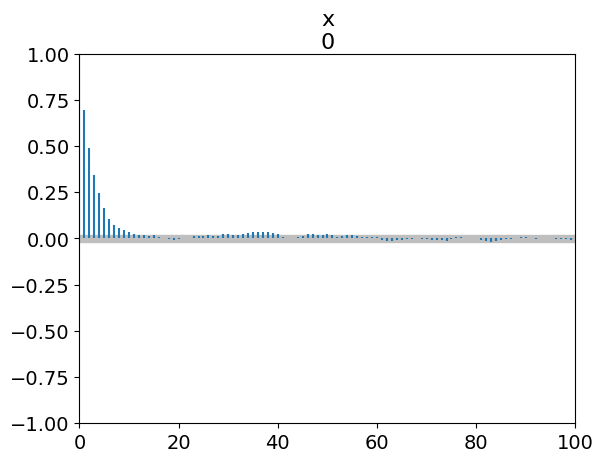

In [13]:
_ = az.plot_autocorr(simple_inf_data)

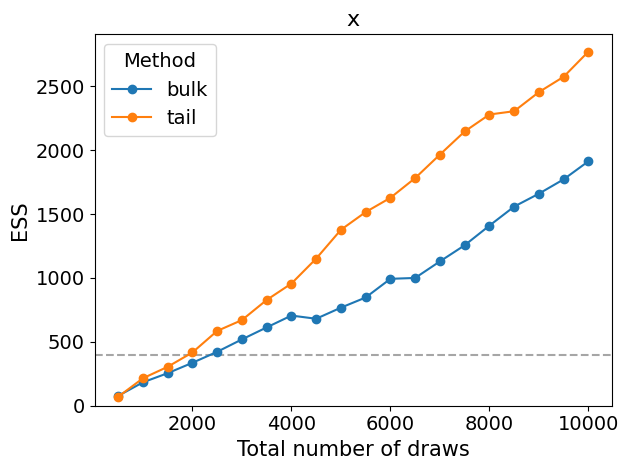

In [14]:
_ = az.plot_ess(simple_inf_data, kind="evolution")
plt.tight_layout()

## Other Algorithms Beyond MCMC
MCMC works well, and often it is all you need. However, there are a plethora of sampling algorithms to explore. Here are a few you may encounter.

### Parallel Tempering (Replica Exchange Monte Carlo)
Our test distribution above was bimodal, but there was enough overlap for the sampler to explore both modalities. 
What would happen as we increase the bimodality?

In [15]:
def p_big_bimodal(x):
    return 0.5 * (pdf(x, mu=0, sigma=2.0) + pdf(x, mu=30, sigma=1))


key , _= jax.random.split(key)
x0 = -7.0
x = x0
p_current = p_big_bimodal(x0)
chain = [x]
probs = [p_current]

niter = 10000
sigma_jump = 5.

for i in tqdm(range(niter)):
    xp = norm.rvs(loc=x, scale=sigma_jump)
    p_p = p_big_bimodal(xp)
    
    α = p_p/p_current
    u = jax.random.uniform(key)
    key, _ = jax.random.split(key)
    accepted = u < α
    
    if accepted:
        x = xp
        p_current = p_p
    chain.append(x)
    probs.append(p_current)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3401.85it/s]


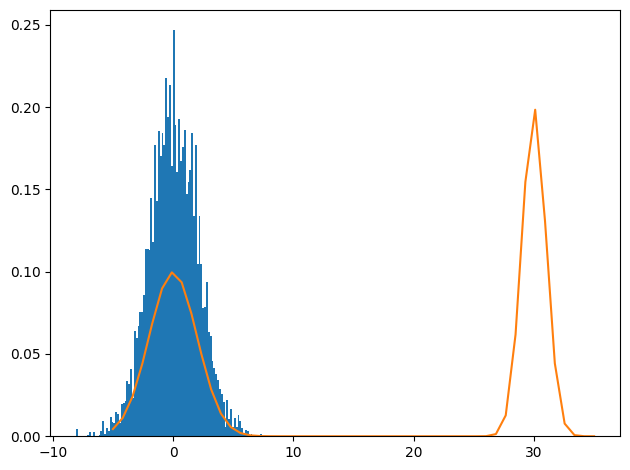

In [16]:
plt.hist(chain, bins=100, density=True)
_ = plt.plot(jnp.linspace(-5,35), p_big_bimodal(jnp.linspace(-5,35)))
plt.tight_layout()

The sampler never explores the other modality. How can [parallel tempering](wiki:Parallel_tempering) fix that?
1. "Temper" the log density:  $e^{\beta \cdot p(y \mid \theta) p(\theta)},\, \beta = 1/T$ 
    - High temperatures flatten the posterior surface, allowing our chains to explore more space 
2. Run many temperatures in parallel and propose swaps between them

## Using Gradient Information
What if instead of a random walk, we wanted to *guide* our sampler?
This is where [Hamiltonian Monte Carlo](wiki:Hamiltonian_Monte_Carlo) (HMC) shines.

HMC essentially sets up a Hamiltonian for our probabilistic model and solves Hamilton's equations.
As such, we now have *equations of motion* for our sampler.

![](./figs/hmc.webp)

This helps *tremendously* with posteriors that have strange geometries or high dimension. 

The general algorithm is:
1. Define potential energy to be $U(x) = -\nabla_{\theta}\, \left(p (y\mid \theta)p(\theta)\right)$
2. Sample kinetic energy from a proposal distribution
3. Solve Hamilton's equations numerically with a symplectic integrator for $L$ steps of stepsize $\epsilon$
4. Accept or reject the final position with a Metropolis step as in standard MCMC
5. Repeat 2--4

An alternative to HMC is the No-U-Turn Sampler (NUTS) [@https://doi.org/10.48550/arXiv.1111.4246].
NUTS aims to fix some issues with hyperparameter tuning in HMC, and it's extremely prevalent in Bayesian inference.

NUTS removes the need to carefully tune the number of steps $L$: it is an *adaptive* algorithm that chooses the best $L$ to properly explore the posterior.
It follows the same algorithm as HMC, but for each iteration solves Hamilton's equations forwards and backwards in time (reverses momentum sign) until the sampler makes a U-Turn (positions get closer together instead of further apart).

See https://chi-feng.github.io/mcmc-demo/

Let's sample our simple 2D Gaussian model from earlier with the NUTS sampler from `NumPyro`.

In [18]:
key, _ = jax.random.split(key)
nuts_mcmc = infer.MCMC(infer.NUTS(simple_2d_gaussian), num_warmup=500, num_samples=1000, num_chains=3, chain_method="sequential")
nuts_mcmc.run(key, data)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1745.25it/s, 3 steps of size 7.80e-01. acc. prob=0.89]


In [19]:
gauss_inf_data = az.from_numpyro(nuts_mcmc)
az.summary(gauss_inf_data, var_names="~cov_mat")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cov_diag[0],0.892,0.058,0.787,1.002,0.001,0.001,3620.0,1978.0,1.0
cov_diag[1],1.026,0.067,0.902,1.156,0.001,0.001,3098.0,1812.0,1.0
mu[0],1.986,0.042,1.910,2.067,0.001,0.001,3498.0,2088.0,1.0
mu[1],2.968,0.043,2.879,3.044,0.001,0.001,3030.0,2242.0,1.0


In [20]:
az.rhat(gauss_inf_data,var_names="~cov_mat")

<xarray.Dataset> Size: 64B
Dimensions:         (cov_diag_dim_0: 2, mu_dim_0: 2)
Coordinates:
  * cov_diag_dim_0  (cov_diag_dim_0) int64 16B 0 1
  * mu_dim_0        (mu_dim_0) int64 16B 0 1
Data variables:
    cov_diag        (cov_diag_dim_0) float64 16B 0.9994 1.0
    mu              (mu_dim_0) float64 16B 1.0 1.003

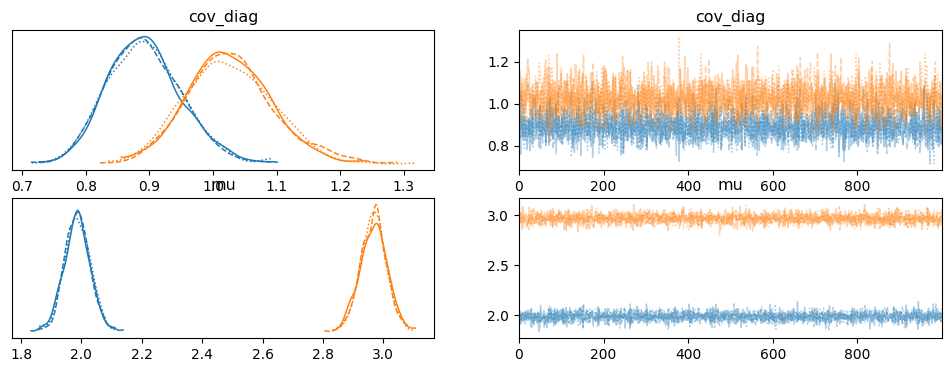

In [21]:
_ = az.plot_trace(gauss_inf_data, var_names="~cov_mat")

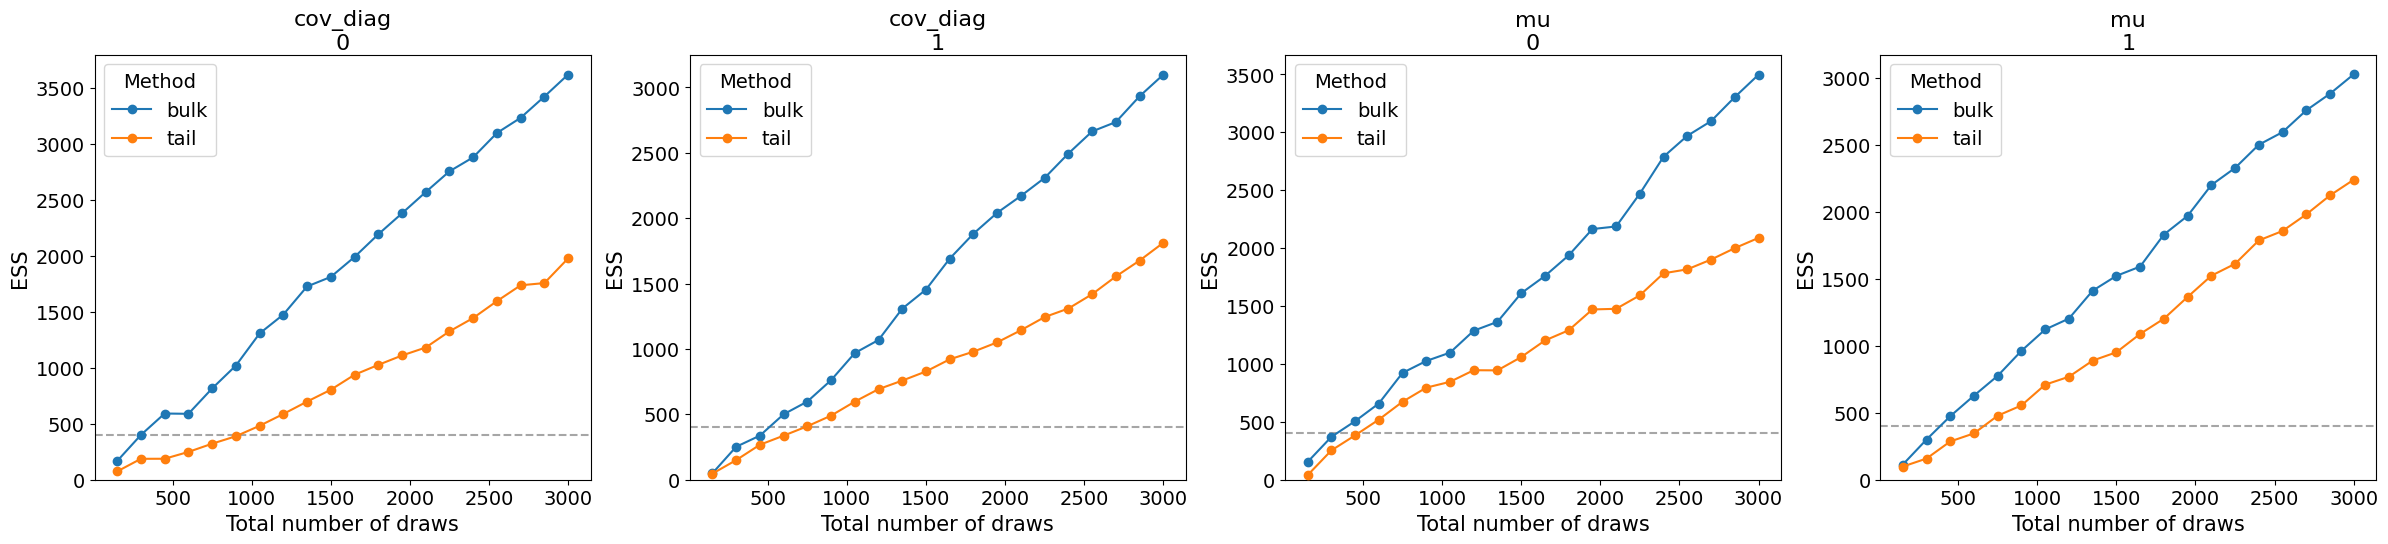

In [22]:
_ = az.plot_ess(gauss_inf_data, var_names="~cov_mat", kind="evolution")

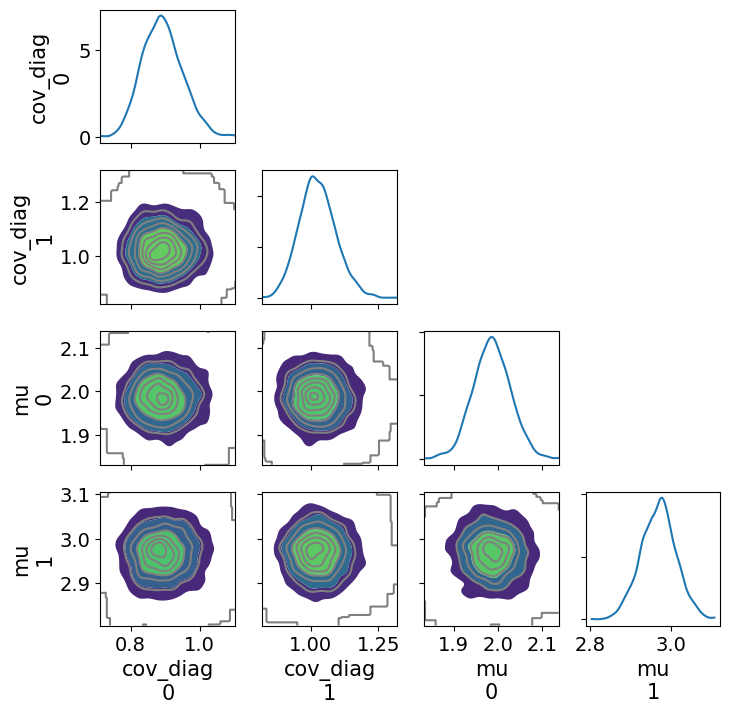

In [23]:
_ = az.plot_pair(gauss_inf_data, var_names="~cov_mat", kind="kde", marginals=True, figsize=(8,8))

```{exercise}
:label: exercise-sampling
Using `NumPyro` NUTS or a sampler of your choice, sample the $H(z)$ model you built in the previous section.
Make some summary plots with `ArviZ`, and check your convergence statistics.
```

````{solution} exercise-sampling
:class: dropdown
```{code} python
hz_nuts = infer.MCMC(infer.NUTS(hz_model), num_warmup = 500, num_samples = 1000, num_chains=3)
hz_nuts.run(hz_nuts, df['z'].to_numpy(), df['H_z'].to_numpy(), df['H_z_err'].to_numpy())

hz_inf_data = az.from_numpyro(hz_nuts)
```
````

# Bayesian Model Comparison
Now we know how to build models infer their unobserved parameters, but how do we know which model to use for our data?
This is where model comparison comes in.

There are many ways to compare Bayesian models and quantify how well each explains your data. Most of these work by finding the [Bayes' factor](wiki:Bayes_factor) for one model over another. Remember the Bayesian evidence $p(y) = \int d\theta p(y\mid\theta) p(\theta)$ that we mentioned earlier? The Bayes' factor for one model over another is the ratio of their evidences.

For models $M_1$ and $M_2$, the Bayes factor 
```{math}
B_{21} = \frac{p(y \mid M_1)}{p(y \mid M_2)}.
```

We can find the evidence either directly, or indirectly. Directly computing the evidence is generally very hard, as mentioned previously. However, there is a class of samplers that can do this: [Nested Sampling](wiki:Nested_sampling_algorithm). 

- Nested sampling is essentially an integration algorithm for the evidence with parameter inference as a side-effect.
It also isn't feasible to implement nested sampling in high dimension.

For indirect methods, I will mention two: product-space sampling and thermodynamic integration.
- Product space sampling works by defining a *product-space model*: a model that considers at least two submodels and treats model selection as a Bayesian problem.
For example, we could have a latent variable $n$ that indexes a list of model likelihoods and selects from them.
    - After running our chains, the ratio of the number of samples in one model over another gives us the Bayes' factor
- Thermodynamic integration is made possible by parallel tempering. We define an integral over the different temperature posterior samples that approximates the Bayesian evidence. 
```{math}
\begin{align}
E_T(x) &\equiv E\left[\exp{\left(T^{-1} \cdot x\right)}\right] \\
\log(Z) &= \int dT\ E_T(p(y \mid \theta)).
\end{align}
```


````{exercise}
:label: model-comp
Use the following template to run nested sampling with your `hz` model from earlier. 
Then, make a new model where the `w0` and `wa` coefficients are allowed to vary.
Compute the Bayes' factor for varied model over the base model.

```{code} python
from numpyro.contrib.nested_sampling import NestedSampler

key, _ = jax.random.split(key)
ns = NestedSampler(hz_model) 
ns.run(key, df['z'].to_numpy(), df['H_z'].to_numpy(), df['H_z_err'].to_numpy())
ns.print_summary()  # Evidence will be log Z

```
````


````{solution} model-comp
:class: dropdown

```{code} python
from numpyro.contrib.nested_sampling import NestedSampler

key, _ = jax.random.split(key)
ns = NestedSampler(hz_model) 
ns.run(key, df['z'].to_numpy(), df['H_z'].to_numpy(), df['H_z_err'].to_numpy())
ns.print_summary()  # Evidence will be log Z

def hz_model_w0_wa(z, hz, hz_err):
    h0 = numpyro.sample("h0", dist.Uniform(50,100))
    w0 = numpyro.sample("w0", dist.Uniform(-2, 0))
    wa = numpyro.sample("wa", dist.Uniform(-2, 0))
    with numpyro.plate("data", hz.shape[0]):
        numpyro.sample("loglike", dist.Normal(hz_forward(z, h0=h0, w0=w0, wa=wa), hz_err), obs=hz)

# Check the model
numpyro.render_model(hz_model_w0_wa, model_args=(df['z'].to_numpy(), df['H_z'].to_numpy(), df['H_z_err'].to_numpy()), render_distributions=True)


key, _ = jax.random.split(key)
ns_w0_wa = NestedSampler(hz_model_w0_wa) 
ns_w0_wa.run(key, df['z'].to_numpy(), df['H_z'].to_numpy(), df['H_z_err'].to_numpy())
ns_w0_wa.print_summary()  # Evidence will be log Z
```
Expected result is roughly `jnp.log10(-249 - -29271) = 4.46`, so $BF_{\Lambda CDM,\, w_0 w_a} \approx 10^4$ ! The $H(z)$ data you used was actually *not* $\Lambda CDM$. It was generated with $w_0=-0.2,\, w_a=-1.5,\, H_0=67 \textrm{ km/s/Mpc}$.
 
````